# Projeto: predição de risco de acidente vascular cerebral (AVC)

O acidente vascular cerebral (AVC) é uma condição médica grave que ocorre quando há interrupção ou redução do fluxo sanguíneo para uma parte do cérebro, resultando em danos às células cerebrais. Representa uma das principais causas de morte no mundo e pode ter consequências graves, tanto físicas quanto cognitivas. Diante de sua alta incidência e impacto, a previsão do risco de desenvolvimento de AVC torna-se essencial para a adoção de medidas preventivas eficazes. Identificar precocemente indivíduos em maior risco permite intervenções clínicas e mudanças no estilo de vida que podem reduzir a ocorrência de novos casos e melhorar a qualidade de vida da população.

O conjunto de dados utilizado neste projeto foi construído com base em literatura médica, consultas a especialistas e modelagem estatística. As distribuições e relações de características foram inspiradas em observações clínicas do mundo real, garantindo validade médica. Nele há 70.000 registros e 18 características relacionadas a fatores de risco para desfecho de acidente vascular cerebral.

Fonte dos dados: [Kaggle](https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset)

## Dicionário de dados


`Chest Pain`: dor no peito -> 0 = Não, 1 = Sim;

`Shortness of Breath`: dificuldade para respirar -> 0 = Não, 1 = Sim;

`Irregular Heartbeat`: batimento cardíaco irregular -> 0 = Não, 1 = Sim;

`Fatigue & Weakness`: fadiga persistente e fraqueza muscular -> 0 = Não, 1 = Sim;

`Dizziness`: tonturas frequentes -> 0 = Não, 1 = Sim;

`Swelling (Edema)`: inchaço nas extremidades devido à retenção de líquidos -> 0 = Não, 1 = Sim;

`Pain in Neck/Jaw/Shoulder/Back`: dor no pescoço, mandíbula, ombro e costas -> 0 = Não, 1 = Sim;

`Excessive Sweating`: suor excessivo -> 0 = Não, 1 = Sim;

`Persistent Cough`: tosse crônica -> 0 = Não, 1 = Sim;

`Nausea/Vomiting`: náuseas ou vômitos frequentes -> 0 = Não, 1 = Sim;

`High Blood Pressure`: pressão alta -> 0 = Não, 1 = Sim;

`Chest Discomfort (Activity)`: desconforto no peito durante atividade física -> 0 = Não, 1 = Sim;

`Cold Hands/Feet`: frequentemente está com extremidades (mãos e pés) frias -> 0 = Não, 1 = Sim;

`Snoring/Sleep Apnea`: apneia do sono -> 0 = Não, 1 = Sim;

`Anxiety/Feeling of Doom`: ansiedade frequente ou sensação de desgraça iminente -> 0 = Não, 1 = Sim;

`Stroke Risk (%)`: risco percentual estimado de ter um acidente vascular cerebral -> valor contínuo de porcentagem (0-100%);

`At Risk (Binary)`: classificada como risco de acidente vascular cerebral -> 0 = Não, 1 = Sim;

`Age`: idade do indivíduo -> valor contínuo;

## Importações e ajustes iniciais

In [118]:
# Frameworks
import numpy as np
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt

# Modelagem
from joblib import dump
from lightgbm import LGBMRegressor
import shap
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import brier_score_loss, root_mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)
from xgboost import XGBRegressor

# Configurações
from src.config import DADOS_LIMPOS, MODELO_FINAL_REG, MODELO_FINAL_REG_DL
from src.reg_graphics import (
    plot_compare_models_metrics,
    plot_estimator_residuals,
)
from src.reg_models import (
    RANDOM_STATE,
    grid_search_cv_regressor,
    organize_results,
    train_validate_regression_model
)

# Avisos
import warnings

In [2]:
# Ajustes
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format

## Modelagem - Regressão

### Verificação inicial dos dados

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

In [4]:
df.head()

,age,anxiety_feeling_of_doom,at_risk,chest_discomfort_activity,chest_pain,cold_hands_feet,dizziness,excessive_sweating,fatigue_weakness,high_blood_pressure,irregular_heartbeat,nausea_vomiting,pain_in_neck_jaw_shoulder_back,persistent_cough,shortness_of_breath,snoring_sleep_apnea,stroke_risk,swelling_edema
0,54,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,58.00,No
1,49,No,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,No,Yes,40.50,Yes
2,62,No,Yes,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,Yes,52.00,Yes
3,48,No,Yes,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,60.00,Yes
4,61,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,Yes,No,No,No,Yes,56.50,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68979 entries, 0 to 68978
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   age                             68979 non-null  int8    
 1   anxiety_feeling_of_doom         68979 non-null  category
 2   at_risk                         68979 non-null  category
 3   chest_discomfort_activity       68979 non-null  category
 4   chest_pain                      68979 non-null  category
 5   cold_hands_feet                 68979 non-null  category
 6   dizziness                       68979 non-null  category
 7   excessive_sweating              68979 non-null  category
 8   fatigue_weakness                68979 non-null  category
 9   high_blood_pressure             68979 non-null  category
 10  irregular_heartbeat             68979 non-null  category
 11  nausea_vomiting                 68979 non-null  category
 12  pain_in_neck_jaw_s

### Comparação inicial entre modelos

Primeiro serão definidas algumas variáveis úteis para todo o notebook e serão separados os dados de treino e teste. Como este será um modelos de regressão, também será excluída a coluna que indica o desfecho por meio de classes.

Durante o treinamento será realizada uma validação cruzada para melhor treinar o modelo, porém neste momento serão serparados dados de treino e dados de teste para somente os dados de treino passarem pela validação cruzada, enquanto os dados de teste serão passados para o modelo apenas ao final, para validar a performance do treinamento realizado.

In [6]:
df.drop(columns="at_risk", inplace=True)

In [7]:
numeric_column = ["age"]
target_column_reg = "stroke_risk"
binary_columns = [column for column in df.columns if column not in (numeric_column + [target_column_reg])]

In [8]:
X = df.drop(columns=target_column_reg)
y = df[target_column_reg]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

Serão criados dois tipos de preprocessamento: um simples, somente para as features categóricas ou categóricas com padronização simples da numérica (de acordo com o mínimo necessário para o modelo) e outro com as categóricas e padronização mais robusta da numérica.

Inicialmente, para comparação entre os modelos, serão usados apenas os simples. Após escolha do melhor modelo, na parte de otimizações, será avaliado qual preprocessamento performa melhor.

In [10]:
preprocessing_cat = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
    ],
    remainder="passthrough"
)

preprocessing_basic = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("standard_scaler", StandardScaler(), numeric_column),
    ],
    remainder="passthrough"
)

preprocessing_robust = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("robust_scaler", RobustScaler(), numeric_column),
    ],
    remainder="passthrough"
)

Neste momento serão avaliados vários modelos de regressão sem otimizações, para verificar quais performam melhor. Desta avaliação derivará o modelo (ou mais de um, se houver performances semelhantes) que será escolhido para etapas futuras de otimização de hiperparâmetros.

Para comparação foram escolhidos alguns modelos de árvore, pois são os que costumam performar melhor em dados da área da saúde, dois modelos de regressão linear (com e sem regularização) e um modelo que trabalha com a ideia de distância entre os pontos.

In [11]:
regs = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor()
    },
    "LinearRegression": {
        "preprocessor": preprocessing_basic,
        "regressor": LinearRegression()
    },
    "ElasticNet": {
        "preprocessor": preprocessing_basic,
        "regressor": ElasticNet()
    },
    "RandomForestRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "LGBMRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    "XGBRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "kNN": {
        "preprocessor": preprocessing_basic,
        "regressor": KNeighborsRegressor(n_neighbors=3, weights="distance"),
    },
}

In [12]:
results = {
    model_name: train_validate_regression_model(X_train, y_train, n_splits=7, **regressor)
    for model_name, regressor in regs.items()
}

df_results = organize_results(results)

In [13]:
df_results.groupby("model").mean().sort_values("test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.01,0.00,-0.00,-11.67,-14.33,0.01
ElasticNet,0.28,0.08,0.63,-6.94,-8.66,0.35
kNN,0.27,2.53,0.95,-2.64,-3.32,2.80
RandomForestRegressor,14.14,0.36,0.96,-2.25,-2.82,14.50
XGBRegressor,1.27,0.08,0.99,-1.07,-1.34,1.35
LGBMRegressor,0.85,0.09,0.99,-0.85,-1.06,0.94
LinearRegression,0.29,0.07,1.00,-0.00,-0.01,0.36


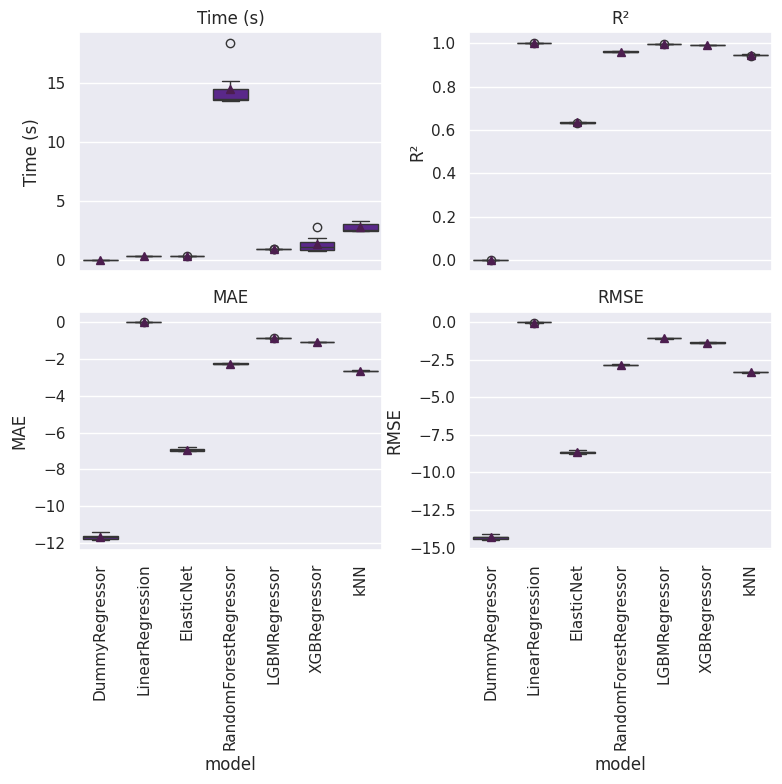

In [14]:
plot_compare_models_metrics(df_results)

Todos os modelos performaram muito bem e muito melhor que o dummy, sendo o desempate possível mais por questão de tempo de execução, tendo LinearRegression, XGBoost e LightGBM como melhores. Como a performance está muito boa mesmo sem otimização de hiperparâmetros, pode-se verificar se é possível simplificar mais o modelo reduzindo a quantidade de features a serem imputadas.

Acredito que este cenário de todos os modelos irem muito bem não costuma ser muito comum para dados reais, então mesmo que a seleção de features diminua um pouco a performance, seguirei com ela apenas para poder treinar o uso de otimização de hiperparâmetros, dado que este projeto tem a finalidade de estudo.



### Seleção de features

Como comentado acima, dada a performance muito boa da maioria dos modelos, será feita uma seleção de features para diminuir a complexidade do modelo, podendo também evitar overfitting.

In [15]:
NUMBER_FINAL_FEATURES = 12

In [16]:
preprocessing_kbest = preprocessing_basic
X_train_scaled = preprocessing_kbest.fit_transform(X_train, y_train)

selector_mi = SelectKBest(mutual_info_regression, k=NUMBER_FINAL_FEATURES)
selector_mi.fit_transform(X_train_scaled, y_train)

selected_mask = selector_mi.get_support()
feature_names = preprocessing_kbest.get_feature_names_out()
selected_feature_names = feature_names[selected_mask]

print("Features selecionadas:", selected_feature_names)

Features selecionadas: ['ohe__anxiety_feeling_of_doom_Yes' 'ohe__chest_discomfort_activity_Yes'
 'ohe__chest_pain_Yes' 'ohe__dizziness_Yes' 'ohe__excessive_sweating_Yes'
 'ohe__high_blood_pressure_Yes' 'ohe__irregular_heartbeat_Yes'
 'ohe__persistent_cough_Yes' 'ohe__shortness_of_breath_Yes'
 'ohe__snoring_sleep_apnea_Yes' 'ohe__swelling_edema_Yes'
 'standard_scaler__age']


In [17]:
columns_to_keep = []

for column in selected_feature_names:
  column = column.split("__")[1].split("_Yes")[0]
  columns_to_keep.append(column)

print("Colunas que serão mantidas:", columns_to_keep)

Colunas que serão mantidas: ['anxiety_feeling_of_doom', 'chest_discomfort_activity', 'chest_pain', 'dizziness', 'excessive_sweating', 'high_blood_pressure', 'irregular_heartbeat', 'persistent_cough', 'shortness_of_breath', 'snoring_sleep_apnea', 'swelling_edema', 'age']


Dada a seleção realizada, os dados de X tanto de treino quanto de teste serão alterados para mater apenas as features selecionadas.

In [18]:
X_train = X_train.drop(columns=[column for column in X_train.columns if column not in columns_to_keep])
X_test = X_test.drop(columns=[column for column in X_test.columns if column not in columns_to_keep])

Os mesmos modelos serão novamente comparados, desta vez utilizando os dados de X com a seleção de features.

In [19]:
binary_columns = [column for column in X_train.columns if column not in (numeric_column)]

In [20]:
preprocessing_cat = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
    ],
    remainder="passthrough"
)

preprocessing_basic = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("standard_scaler", StandardScaler(), numeric_column),
    ],
    remainder="passthrough"
)

preprocessing_robust = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("robust_scaler", RobustScaler(), numeric_column),
    ],
    remainder="passthrough"
)

In [21]:
regs_select = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor()
    },
    "LinearRegression": {
        "preprocessor": preprocessing_basic,
        "regressor": LinearRegression()
    },
    "ElasticNet": {
        "preprocessor": preprocessing_basic,
        "regressor": ElasticNet()
    },
    "RandomForestRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "LGBMRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    "XGBRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "kNN": {
        "preprocessor": preprocessing_basic,
        "regressor": KNeighborsRegressor(n_neighbors=3, weights="distance"),
    },
}

In [22]:
results_select = {
    model_name: train_validate_regression_model(X_train, y_train, n_splits=7, **regressor)
    for model_name, regressor in regs_select.items()
}

df_results_select = organize_results(results_select)

In [23]:
df_results_select.groupby("model").mean().sort_values("test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00,0.00,-0.00,-11.67,-14.33,0.01
ElasticNet,0.22,0.06,0.59,-7.34,-9.16,0.27
kNN,0.60,1.25,0.80,-5.08,-6.36,1.85
RandomForestRegressor,15.89,0.47,0.84,-4.63,-5.73,16.36
XGBRegressor,0.59,0.05,0.87,-4.17,-5.20,0.64
LGBMRegressor,0.93,0.08,0.87,-4.02,-5.09,1.02
LinearRegression,0.22,0.06,0.88,-3.75,-4.99,0.28


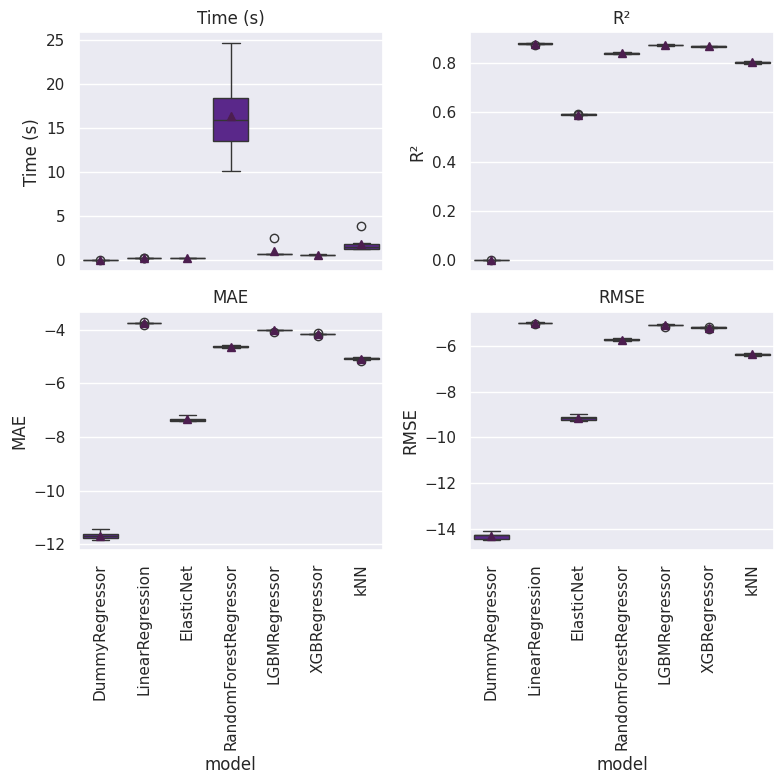

In [24]:
plot_compare_models_metrics(df_results_select)

Após a seleção de features as métricas diminuíram um pouco, mas para uma simplificação de 18 para 12 features, não foi uma queda tão acentuada nos valores.

Os melhores modelos praticamente empatados em performance e com tempo de execução menores foram LinearRegression, LightGBM e XGBoost.

Deste modo, a seguir serão otimizados hiperparâmetros desses três modelos, que serão comparados ao final para decidir o melhor. Além disso, serão mantidas apenas as 12 features selecionadas.

### Otimização de hiperparâmetros

#### LinearRegression

In [25]:
param_grid_lr = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")],
    "regressor__preprocessor": [preprocessing_basic, preprocessing_robust],
}

In [26]:
reg_lr = LinearRegression(n_jobs=-1)

grid_search_lr = grid_search_cv_regressor(reg_lr, param_grid_lr, preprocessor=preprocessing_basic, target_transformer=PowerTransformer(), n_splits=7)

grid_search_lr.fit(X_train, y_train)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ohe',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['anxiety_feeling_of_doom',
                                                                                                               'chest_discomfort_activity',
                                                                                                               'chest_pain',
                                                                                                               'dizziness',
                                                                                                               'excessive_sweating',
                                                                                                               'high_blood_pres...
                                                                                       'irregular_heartbeat',
                                                                                       'persistent_cough',
                                                                                       'shortness_of_breath',
                                                                                       'snoring_sleep_apnea',
                                                                                       'swelling_edema']),
                                                                                     ('robust_scaler',
                                                                                      RobustScaler(),
                                                                                      ['age'])])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [27]:
grid_search_lr.best_params_

{'regressor__preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe', OneHotEncoder(drop='first'),
                                  ['anxiety_feeling_of_doom',
                                   'chest_discomfort_activity', 'chest_pain',
                                   'dizziness', 'excessive_sweating',
                                   'high_blood_pressure', 'irregular_heartbeat',
                                   'persistent_cough', 'shortness_of_breath',
                                   'snoring_sleep_apnea', 'swelling_edema']),
                                 ('standard_scaler', StandardScaler(), ['age'])]),
 'transformer': None}

In [28]:
grid_search_lr.best_score_

np.float64(-4.994724208122286)

Com hiperparâmetros otimizados não parece ter havido muita mudança de score (RMSE), mas eles serão mantidos para a avaliação final.

#### LightGBM

In [29]:
scale_pos_weight = np.bincount(y_train)[0] / np.bincount(y_train)[1]

param_grid_lgbm = {
    "reg__max_depth": [6, 10, 30],
    # "reg__num_leaves": [10, 20, 31, 50],  # Número máximo de folhas por árvore
    # "reg__min_child_samples": [25, 50, 100],  # Mínimo de amostras em um nó folha
    # "reg__min_split_gain": [0.1, 0.25, 0.5],  # Redução mínima de perda para divisão
    "reg__subsample": [0.4, 0.6, 0.8],  # Proporção de amostras usadas para cada árvore
    "reg__colsample_bytree": [0.4, 0.6, 0.8],  # Proporção de features para construção de cada árvore
    "reg__learning_rate": [0.05, 0.1, 0.3],
    # "reg__n_estimators": [10, 50, 100],
    # "reg__reg_alpha": [0.0, 0.5, 1.0],  # Regularização L1
    # "reg__reg_lambda": [0.0, 0.5, 1.0],  # Regularização L2
    "reg__scale_pos_weight": [1, scale_pos_weight],
    # "preprocessor": [preprocessing_basic, preprocessing_robust],
    # "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")],
}

In [30]:
reg_lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)

In [31]:
grid_search_lgbm = grid_search_cv_regressor(reg_lgbm, param_grid_lgbm, preprocessing_cat, n_splits=7)

grid_search_lgbm.fit(X_train, y_train)

Fitting 7 folds for each of 162 candidates, totalling 1134 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['anxiety_feeling_of_doom',
                                                                          'chest_discomfort_activity',
                                                                          'chest_pain',
                                                                          'dizziness',
                                                                          'excessive_sweating',
                                                                          'high_blood_pressure',
                                                                          'irregular_heartbeat',
                                                                          'persiste...
                                        LGBMRegressor(n_jobs=-1,
                                                      random_state=42,
                                                      verbose=-1))]),
             n_jobs=-1,
             param_grid={'reg__colsample_bytree': [0.4, 0.6, 0.8],
                         'reg__learning_rate': [0.05, 0.1, 0.3],
                         'reg__max_depth': [6, 10, 30],
                         'reg__scale_pos_weight': [1, np.float64(nan)],
                         'reg__subsample': [0.4, 0.6, 0.8]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Os itens comentados no param_grid são outros hiperparâmetros comuns de serem testados e que só não foram testados neste projeto por questão de tempo de execução do fit.

In [32]:
grid_search_lgbm.best_params_

{'reg__colsample_bytree': 0.4,
 'reg__learning_rate': 0.1,
 'reg__max_depth': 6,
 'reg__scale_pos_weight': 1,
 'reg__subsample': 0.4}

In [33]:
grid_search_lgbm.best_score_

np.float64(-5.036847714079808)

Com hiperparâmetros otimizados houve uma leve melhora de score (RMSE), que serão mantidos para a avaliação final. Se testar outros hiperparâmentros (por exemplo os que foram comentados) pode ser que haja uma melhora maior.

#### XGBoost

In [34]:
param_grid_xgb = {
    "reg__max_depth": [6, 10, 30],
    # "reg__min_child_weight": [3, 5, 8],  # Peso mínimo de uma folha
    # "reg__gamma": [0.1, 0.25, 0.5],  # Redução mínima de perda para uma divisão
    "reg__subsample": [0.4, 0.6, 0.8],
    "reg__colsample_bytree": [0.4, 0.6, 0.8],
    "reg__learning_rate": [0.05, 0.1, 0.3],
    # "reg__n_estimators": [10, 50, 100],  # Número de árvores
    # "reg__reg_lambda": [1, 2, 5],  # Regularização L2
    # "reg__reg_alpha": [0, 0.5, 1],  # Regularização L1
    "reg__scale_pos_weight": [1, scale_pos_weight],
    # "preprocessor": [preprocessing_basic, preprocessing_robust],
    # "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")],
}

In [35]:
reg_xgb = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [36]:
grid_search_xgb = grid_search_cv_regressor(reg_xgb, param_grid_xgb, preprocessing_cat, n_splits=7)

grid_search_xgb.fit(X_train, y_train)

Fitting 7 folds for each of 162 candidates, totalling 1134 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['anxiety_feeling_of_doom',
                                                                          'chest_discomfort_activity',
                                                                          'chest_pain',
                                                                          'dizziness',
                                                                          'excessive_sweating',
                                                                          'high_blood_pressure',
                                                                          'irregular_heartbeat',
                                                                          'persiste...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'reg__colsample_bytree': [0.4, 0.6, 0.8],
                         'reg__learning_rate': [0.05, 0.1, 0.3],
                         'reg__max_depth': [6, 10, 30],
                         'reg__scale_pos_weight': [1, np.float64(nan)],
                         'reg__subsample': [0.4, 0.6, 0.8]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Os itens comentados no param_grid são outros hiperparâmetros comuns de serem testados e que só não foram testados neste projeto por questão de tempo de execução do fit.

In [37]:
grid_search_xgb.best_params_

{'reg__colsample_bytree': 0.4,
 'reg__learning_rate': 0.3,
 'reg__max_depth': 6,
 'reg__scale_pos_weight': 1,
 'reg__subsample': 0.8}

In [38]:
grid_search_xgb.best_score_

np.float64(-5.030143276014051)

Com hiperparâmetros otimizados houve melhora de score (RMSE), que serão mantidos para a avaliação final. Se testar outros hiperparâmentros (por exemplo os que foram comentados) pode ser que haja uma melhora maior.

#### Comparação final

In [39]:
regs_final = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor()
    },
    "LinearRegression": {
        "preprocessor": preprocessing_basic,
        "regressor": LinearRegression(n_jobs=-1)
    },
    "LGBMRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": grid_search_lgbm.best_estimator_["reg"]
    },
    "XGBRegressor": {
        "preprocessor": preprocessing_cat,
        "regressor": grid_search_xgb.best_estimator_["reg"]
    },
}

In [40]:
results_final = {
    model_name: train_validate_regression_model(X_train, y_train, n_splits=7, **regressor)
    for model_name, regressor in regs_final.items()
}

df_results_final = organize_results(results_final)

In [41]:
df_results_final.groupby("model").mean().sort_values("test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00,0.00,-0.00,-11.67,-14.33,0.01
LGBMRegressor,0.63,0.08,0.88,-3.93,-5.04,0.72
XGBRegressor,0.93,0.06,0.88,-3.91,-5.03,0.99
LinearRegression,0.22,0.06,0.88,-3.75,-4.99,0.28


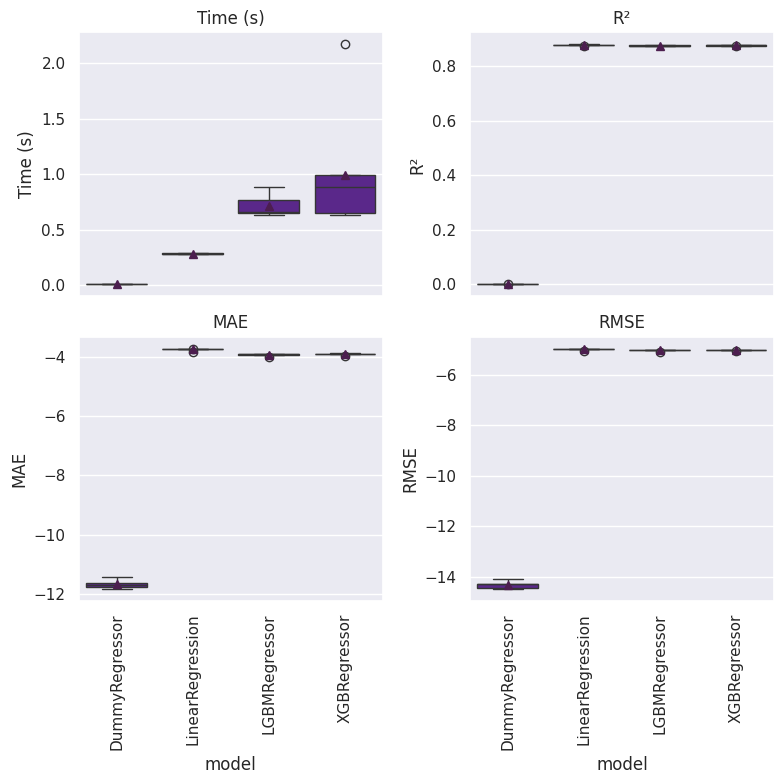

In [42]:
plot_compare_models_metrics(df_results_final)

A partir destes dados percebe-se que os modelos testados possuem performances muito semelhantes, assim como tempos de execução. Apenas por algumas poucas métricas serem ligeiramente melhores e o tempo de execução melhor, o modelo final escolhoido é o LinearRegression.

In [43]:
final_model = grid_search_lr.best_estimator_

### Outros dados do modelo escolhido

Como o modelo final foi de regressão linear, é possível obter algumas visualizações que complementam os detalhes de performance do modelo.

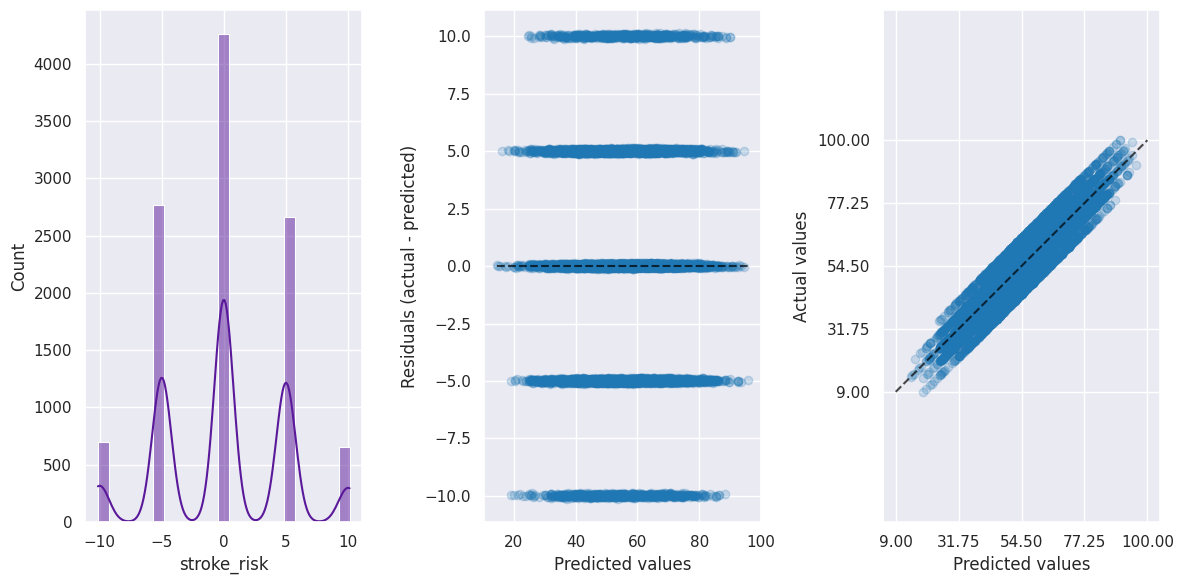

In [44]:
plot_estimator_residuals(final_model, X_train, y_train, sample_fraction=0.2)

Embora o modelo tenha uma boa capacidade de prever a tendência geral (como mostrado no terceiro gráfico), a análise de resíduos (segundo gráfico) revela falhas significativas em suas suposições, pois os pontos não estão distribuídos aleatoriamente e sim em faixas, embora a variável algo seja contínua. Isso também é possível de perceber no primeiro gráfico, apesar de ser possível visualizar nele uma tendência geral de acúmulo de dados mais próximos do zero, apesar dos vários picos.

Desse modo, o modelo final será alterado para o segundo melhor de acordo com o tempo de execução (pois as métricas estão muito similares): LightGBM. Por ser um modelo de árvore, ele também é melhor para capturar dados não explicados por modelos lineares.

In [45]:
final_model = grid_search_lgbm.best_estimator_["reg"]

### Validação final

O modelo escolhido foi testado e otimizado com os dados de treino. Neste momento será realizada a validação final, com os dados de teste, nunca "vistos" pelo modelo.

In [47]:
preprocessing_cat.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['anxiety_feeling_of_doom',
                                  'chest_discomfort_activity', 'chest_pain',
                                  'dizziness', 'excessive_sweating',
                                  'high_blood_pressure', 'irregular_heartbeat',
                                  'persistent_cough', 'shortness_of_breath',
                                  'snoring_sleep_apnea', 'swelling_edema'])])

In [48]:
X_test_transformed = preprocessing_cat.transform(X_test)

In [49]:
y_pred = final_model.predict(X_test_transformed)

In [50]:
rmse_test = root_mean_squared_error(y_test, y_pred)
rmse_test

5.037858996133423

O valor do RMSE para os dados de teste se manteve praticamente estável, similar ao obtido com os dados de treino, mostrando que o modelo está capturando bem o padrão dos dados.

## Conclusão

O modelhor modelo defindo e validado pode passar por algumas avaliações finais apenas para visualizar sua performance.



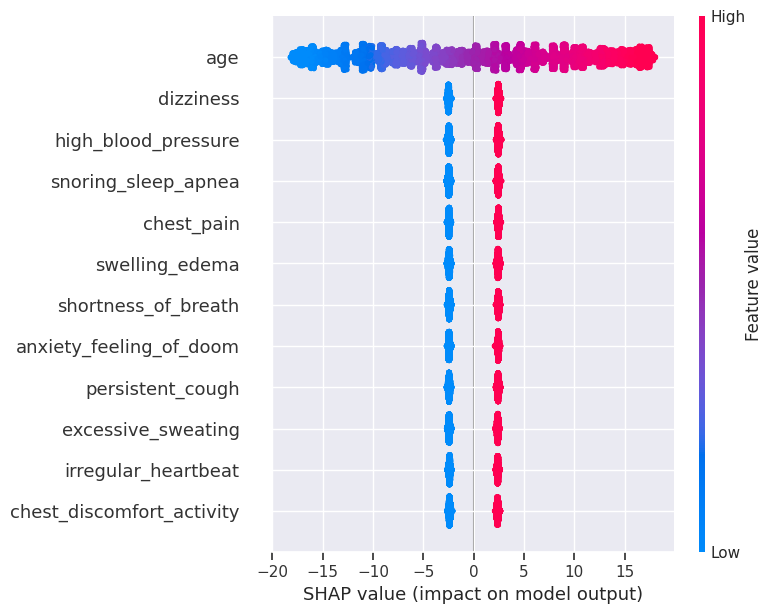

In [51]:
shap.initjs()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, columns_to_keep)

A partir do gráfico acima é possível ver que as features categóricas selecionadas diferenciam bem os resultados e a feature contínua "age" também possui alguns grupos bem distintos, apesar de não serem todas as faixas etárias boas para predição.

Foi definido e validado o melhor modelo para realizar as predições e os melhores parâmetros que ele pode ter para aprimorar o acerto do modelo. Desse modo, é possível usar o modelo obtido para prever novos dados. Para isso basta substituir os valores no "new_prediction" abaixo e executar.

In [69]:
new_prediction = [
    0, # anxiety_feeling_of_doom
    1, # chest_discomfort_activity
    1, # chest_pain
    1, # dizziness
    0, # excessive_sweating
    1, # high_blood_pressure
    1, # irregular_heartbeat
    1, # persistent_cough
    1, # shortness_of_breath
    1, # snoring_sleep_apnea
    1, # swelling_edema
    63, # age
]

new_prediction_df = pd.DataFrame(new_prediction, index=columns_to_keep).T

prediction = final_model.predict(new_prediction_df)
print(f"Probabilidade de chance de AVC de acordo com o modelo: {prediction[0]:.2f}%.")

Probabilidade de chance de AVC de acordo com o modelo: 76.96%.


Por fim, o modelo também será salvo, podendo ser implementado em outras aplicações.

In [ ]:
dump(final_model, MODELO_FINAL_REG)

## Extra: teste de modelo de deep learning

Modelos mais simples já conseguiram capturar o padrão dos dados suficientemente bem, então um modelo de deep learning não seria a melhor escolha para este conjunto de dados, visto o custo computacional envolvido. Porém, apenas para estudo, será realizado também um treino de modelo de deep learning e avaliação de sua performance.

Para evitar risco de overfitting, para este teste serão reaproveitados os dados de X e y após a seleção de features. Além disso, realizando o teste deste modo, é possível comparar a predição final entre o LightGBM (modelo escolhido acima) e o modelo de deep learning utilizando os mesmos valores de entrada.

In [71]:
from tensorflow import keras

In [88]:
X_train_dl = preprocessing_cat.transform(X_train)
y_train_dl = y_train.values

In [104]:
model = keras.Sequential()

model.add(keras.layers.InputLayer(input_shape=(12,)))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

In [105]:
model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError()])

In [106]:
early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    min_delta=0.001,
    start_from_epoch=50
)

history = model.fit(
    X_train_dl,
    y_train_dl,
    epochs=200,
    batch_size=4096,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2393.6782 - root_mean_squared_error: 48.9030 - val_loss: 1735.4202 - val_root_mean_squared_error: 41.6584
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1518.0304 - root_mean_squared_error: 38.9375 - val_loss: 1019.3241 - val_root_mean_squared_error: 31.9269
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 876.9787 - root_mean_squared_error: 29.5882 - val_loss: 567.8749 - val_root_mean_squared_error: 23.8301
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 492.6404 - root_mean_squared_error: 22.1781 - val_loss: 327.4447 - val_root_mean_squared_error: 18.0954
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 292.6893 - root_mean_squared_error: 17.0968 - val_loss: 215.1785 - val_root_mean_squared_error: 14.6690
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 205.1277 - root_mean_squared_error: 14.3201 - val_loss: 183.0315 - val_root_mean_squared_error: 13.5289
Epoch 7/200


É possível verificar uma boa queda do RMSE e do loss ao longo das epochs. Além disso, o valor de RMSE final com os dados de validação é semelhante ao RMSE dos dados de treino do LighGMB quando realizada a validação cruzada.

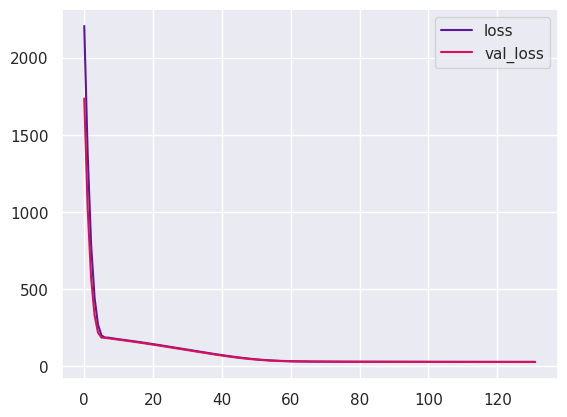

In [107]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

A curva está boa, sem ruídos, com um decréscimo grande inicial e com curvas de treino e validação seguindo percursos semelhantes.

A partir do modelo treinado, será feito o teste com dados ainda não "vistos" pelo modelo.

In [108]:
X_test_dl = preprocessing_cat.transform(X_test)
y_test_dl = y_test.values

In [110]:
model.evaluate(X_test_dl, y_test_dl)

432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 25.6750 - root_mean_squared_error: 5.0660


[25.347230911254883, 5.034603118896484]

A partir da avaliação final do modelo é possível perceber tanto que não houve tanta variação do RMSE entre dados de treino e dados de teste, o que indica que o treinamento foi feito de maneira a ser possível generalizar para dados novos. Além disso, o valor do RMSE na avaliação final de deep learning ficou próximo ao valor de RMSE na avaliação final do LightGBM, indicando que eles possuem capacidades semelhantes de acerto (e erro).

O modelo foi definido e validado. Desse modo, é possível usar o modelo obtido para prever novos dados. Para isso basta substituir os valores no "prediction_dl" abaixo e executar.

In [119]:
prediction_dl = model.predict(np.array([
    0, # anxiety_feeling_of_doom
    1, # chest_discomfort_activity
    1, # chest_pain
    1, # dizziness
    0, # excessive_sweating
    1, # high_blood_pressure
    1, # irregular_heartbeat
    1, # persistent_cough
    1, # shortness_of_breath
    1, # snoring_sleep_apnea
    1, # swelling_edema
    63, # age
]).reshape(1, -1))

print(f"Probabilidade de chance de AVC de acordo com o modelo de deep learning: {prediction_dl[0][0]:.2f}%.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Probabilidade de chance de AVC de acordo com o modelo de deep learning: 76.60%.


No exemplo acima foram usados os mesmos valores que no exemplo de predição com LightGBM. Desse modo, é possível notar que eles produziram predições bem semelhantes.

Por fim, o modelo também será salvo, podendo ser implementado em outras aplicações.

In [ ]:
dump(model, MODELO_FINAL_REG_DL)